In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as t
import pytorch_lightning as pl
import torchaudio as toa
import matplotlib.pyplot as plt
from IPython.display import display, Audio
from src.data.dataset import BirdTrainDataset, BirdTestDataset
%matplotlib inline

In [3]:
import glob
from itertools import chain
import numpy as np
import librosa
import librosa.display

In [4]:
def plot_data(y, sr, ax):
    n_fft = 2048
    n_mels = 128
    hop_length = 512
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, norm=None, htk=True)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=ax);
    #plt.colorbar(format='%+2.0f dB', ax=ax);

In [5]:
train_dataset = BirdTrainDataset(
    '../data/raw/birdsong-recognition/train.csv',
    '../data/raw/birdsong-recognition/train_audio/',
    44100
)

In [6]:
sample_0 = train_dataset[1000]

In [7]:
mel_transform = toa.transforms.MelSpectrogram(
    sample_rate=sample_0['sampling_rate'],
    n_fft=2048,
    n_mels=128,
    hop_length=512,
)

In [8]:
sample_0['waveform'].shape

torch.Size([1, 1568549])

In [9]:
display(Audio(filename=sample_0['filepath']))

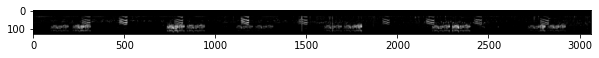

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(librosa.amplitude_to_db(mel_transform(sample_0['waveform'])[0,:,:].numpy()), cmap='gray')

In [11]:
sample_0['duration']

35

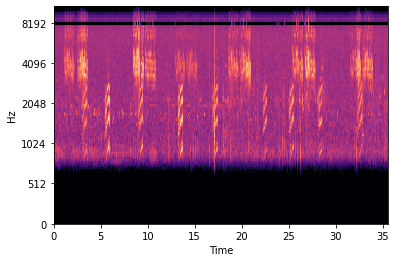

In [12]:
plot_data(sample_0['waveform'].numpy()[0], sample_0['sampling_rate'], plt.gca())

In [13]:
n_fft = 2048
n_mels = 128
hop_length = 512

In [14]:
S1 = librosa.feature.melspectrogram(
    sample_0['waveform'].numpy()[0], sr=sample_0['sampling_rate'],
    n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,
    norm=None,
    htk=True,
)

In [15]:
mel_transform = toa.transforms.MelSpectrogram(
    sample_rate=sample_0['sampling_rate'],
    n_fft=n_fft,
    n_mels=n_mels,
    hop_length=hop_length,
)
S2 = mel_transform(sample_0['waveform'])[0,:,:]

In [16]:
S1

array([[1.55363318e-06, 5.38418426e-05, 1.83612183e-02, ...,
        1.20025317e-04, 6.99619344e-03, 6.57207845e-03],
       [9.07866252e-06, 6.66972774e-05, 1.97034981e-02, ...,
        1.05925887e-04, 7.07538472e-03, 1.13332896e-02],
       [4.86917224e-06, 3.91127505e-05, 1.77757759e-02, ...,
        1.02730766e-04, 6.84241764e-03, 8.04581959e-03],
       ...,
       [6.15554496e-10, 6.40216236e-09, 6.67989809e-07, ...,
        1.39504009e-05, 1.41596493e-05, 4.57958231e-06],
       [5.11113318e-10, 6.12704110e-09, 7.21870606e-07, ...,
        2.70742239e-05, 2.07540088e-05, 4.82475480e-06],
       [5.23830035e-10, 6.26639807e-09, 1.07713663e-06, ...,
        3.12570337e-05, 3.02576082e-05, 9.59718000e-06]], dtype=float32)

In [17]:
S2

tensor([[1.5536e-06, 5.3842e-05, 1.8361e-02,  ..., 1.2003e-04, 6.9962e-03,
         6.5721e-03],
        [9.0787e-06, 6.6697e-05, 1.9704e-02,  ..., 1.0593e-04, 7.0754e-03,
         1.1333e-02],
        [4.8692e-06, 3.9113e-05, 1.7776e-02,  ..., 1.0273e-04, 6.8424e-03,
         8.0458e-03],
        ...,
        [6.1554e-10, 6.4022e-09, 6.6799e-07,  ..., 1.3950e-05, 1.4159e-05,
         4.5795e-06],
        [5.1111e-10, 6.1269e-09, 7.2189e-07,  ..., 2.7074e-05, 2.0754e-05,
         4.8247e-06],
        [5.2383e-10, 6.2663e-09, 1.0772e-06,  ..., 3.1257e-05, 3.0257e-05,
         9.5972e-06]])

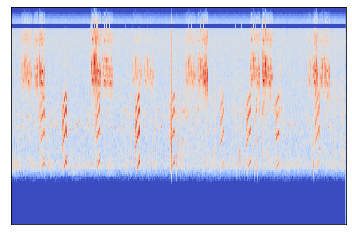

In [18]:
librosa.display.specshow(librosa.power_to_db(S1))

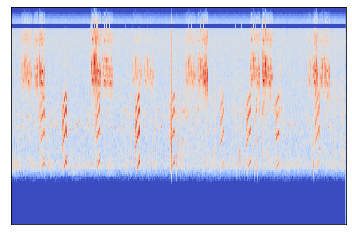

In [19]:
librosa.display.specshow(librosa.power_to_db(S2))

### MelSpectrogram experiments

In [20]:
sample_0['waveform'].shape

torch.Size([1, 1568549])

In [21]:
1223424 / 512

2389.5

In [22]:
sample_0['sampling_rate']

44100

In [23]:
class ExperimentModule(pl.LightningModule):
    def __init__(self, n_classes, n_fft, n_mels, hop_length):
        super().__init__()
        self.conv_1 = t.nn.Conv2d(1, 24, (5, 5))
        self.maxpool_1 = t.nn.MaxPool2d((4, 2))
        self.conv_2 = t.nn.Conv2d(24, 48, (5, 5))
        self.maxpool_2 = t.nn.MaxPool2d((4, 2))
        self.conv_3 = t.nn.Conv2d(48, 48, (5, 5))
        self.dropout = t.nn.Dropout(0.5)
        self.linear = t.nn.Linear(6912, n_classes)
        
        self.n_classes = n_classes
        self.n_fft = n_fft
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.mel_transform = toa.transforms.MelSpectrogram(
            sample_rate=44100,
            n_fft=self.n_fft,
            n_mels=self.n_mels,
            hop_length=self.hop_length,
        )
        
        
    def forward(self, waveform, sampling_rate, batch_size, segment_lengths):
        
        
        
        
        n_segments = max(segment_lengths)
        waveform = waveform.view(n_segments * batch_size, 1, -1)
        
        print(waveform.device)
        
#         print(waveform.shape)
        
        mel_spec = self.mel_transform(waveform)
        
#         print(mel_spec.shape)
        
        x = self.conv_1(mel_spec)
        x = self.maxpool_1(x)
        x = t.relu(x)
        
#         print(x.shape)
        
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        x = t.relu(x)
        
#         print(x.shape)
        
        x = self.conv_3(x)
        
#         print(x.shape)
        
        
        x = x.view(batch_size, n_segments, -1)
        x = self.dropout(x)
        
        # print(x.shape)
        x1 = t.mean(x, dim=1)
        x2, _ = t.max(x, dim=1)

        x = t.cat((x1, x2), dim=-1)
        x = self.linear(x)
        
        return x
    
    def training_step(self, batch, batch_nb):
        prediction = self(
            batch['waveforms'],
            batch['sampling_rate'],
            len(batch),
            batch['segment_lengths']
        )
        loss = t.nn.functional.binary_cross_entropy_with_logits(
            prediction,
            batch['ebird_encoded']
        )
        tensorboard_logs = {'train_loss': loss.item()}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return t.optim.Adam(self.parameters(), lr=0.001)
        
        

In [24]:
# Pad sequences to the same length and to closest round 5 seconds
def collate(batch):
    batch_size = len(batch)
    
    lengths = [x['waveform'].size(1) for x in batch]
    max_length = max(lengths)
    sampling_rate = batch[0]['sampling_rate']
    
    n_seconds = sampling_rate * 2
    k = (max_length // n_seconds) + 1
    padded_length = k * n_seconds
    
    batched_waveforms = t.zeros(batch_size, padded_length)
    batched_masks = t.zeros(batch_size, padded_length)
    
    segment_lengths = [(length // n_seconds) + 1 for length in lengths]
    
    for i, item in enumerate(batch):
        waveform = item['waveform'][0]
        batched_waveforms[i, :len(waveform)] = waveform
        batched_masks[i, :len(waveform)] = 1
    
    primary_labels = [x['primary_label'] for x in batch]
    secondary_labels = [x['secondary_labels'] for x in batch]
    durations = [x['duration'] for x in batch]
    
    print(durations)
    
    ebird_encoded = t.cat([x['ebird_encoded'].view(1, -1) for x in batch], dim=0)
    
    return {
        'waveforms': batched_waveforms,
        'original_lengths': lengths,
        'sampling_rate': sampling_rate,
        'ebird_encoded': ebird_encoded,
        'primary_labels': primary_labels,
        'secondary_labels': secondary_labels,
        'segment_lengths': segment_lengths,
        'durations': durations,
    }

In [25]:
dataloader = t.utils.data.DataLoader(train_dataset, batch_size=5, collate_fn=collate)

In [26]:
batch = next(iter(dataloader))

[25, 36, 39, 33, 36]


In [27]:
batch['waveforms'].shape

torch.Size([5, 1764000])

In [28]:
batch['segment_lengths']

[13, 19, 20, 17, 19]

In [29]:
batch['durations']

[25, 36, 39, 33, 36]

In [30]:
batch['ebird_encoded'].shape

torch.Size([5, 264])

In [31]:
segmented = batch['waveforms'].view(70, 1, -1)

In [32]:
em = ExperimentModule(264, 2048, 128, 512)

In [33]:
after_conv = em(segmented, batch['sampling_rate'], 5, batch['segment_lengths'])

cpu


In [34]:
after_conv.shape

torch.Size([5, 264])

In [35]:
criterion = t.nn.BCEWithLogitsLoss()

In [36]:
criterion(after_conv, batch['ebird_encoded'])

tensor(23.2587, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [37]:
train_dataloader = t.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate,
    num_workers=16,
)

In [38]:
model = ExperimentModule(264, 2048, 128, 512)

In [39]:
trainer = pl.Trainer(gpus=1, accumulate_grad_batches=16)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [40]:
trainer.fit(model, train_dataloader)


  | Name          | Type           | Params
-------------------------------------------------
0 | conv_1        | Conv2d         | 624   
1 | maxpool_1     | MaxPool2d      | 0     
2 | conv_2        | Conv2d         | 28 K  
3 | maxpool_2     | MaxPool2d      | 0     
4 | conv_3        | Conv2d         | 57 K  
5 | dropout       | Dropout        | 0     
6 | linear        | Linear         | 1 M   
7 | mel_transform | MelSpectrogram | 0     


[15]
[17]
[9]
[8]
[41]
[14]
[69]
[3]
[26]
[36]
[4]
[15]
[76]
[116]
[5]
[14]
cuda:0
[153]
[46]
[68]
[66]
[75]
[137]
[29]
[36]
[92]
[166]


RuntimeError: Calculated padded input size per channel: (6 x 2). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [ ]:
!